In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import cv2
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, LeakyReLU
from keras.layers import Cropping2D
from tensorflow.keras import layers
import pandas as pd


import random, numpy as np
SEED = 27
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_images_from_folder(folder_path, target_size=(100, 100)):

    images = []
    filenames = []

    for filename in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img_array = np.array(img)
        images.append(img_array)
        filenames.append(filename)

    return np.array(images), filenames

folder_path = "/content/drive/MyDrive/B_23"
images, filenames = load_images_from_folder(folder_path)

print("Total gambar:", images.shape[0])
print("Shape:", images.shape[1:])
print("nama file:", filenames[:5])

Total gambar: 1074
Shape: (600, 600, 3)
nama file: ['kirmizi 1000.jpg', 'kirmizi 1001.jpg', 'kirmizi 1002.jpg', 'kirmizi 1003.jpg', 'kirmizi 1004.jpg']


# EDA

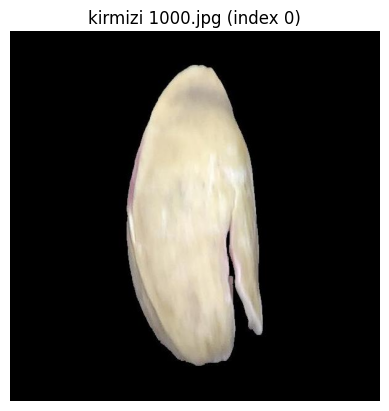

In [ ]:
import matplotlib.pyplot as plt

target_name = "kirmizi 1000.jpg"

if target_name in filenames:
    idx = filenames.index(target_name)
    img = images[idx]
    plt.imshow(img)
    plt.title(f"{target_name} (index {idx})")
    plt.axis('off')
    plt.show()

### Ini range pixel (normal gambar selalu 0-255)

In [ ]:
print(f"Value range: [{images.min()}, {images.max()}]")

Value range: [0, 255]


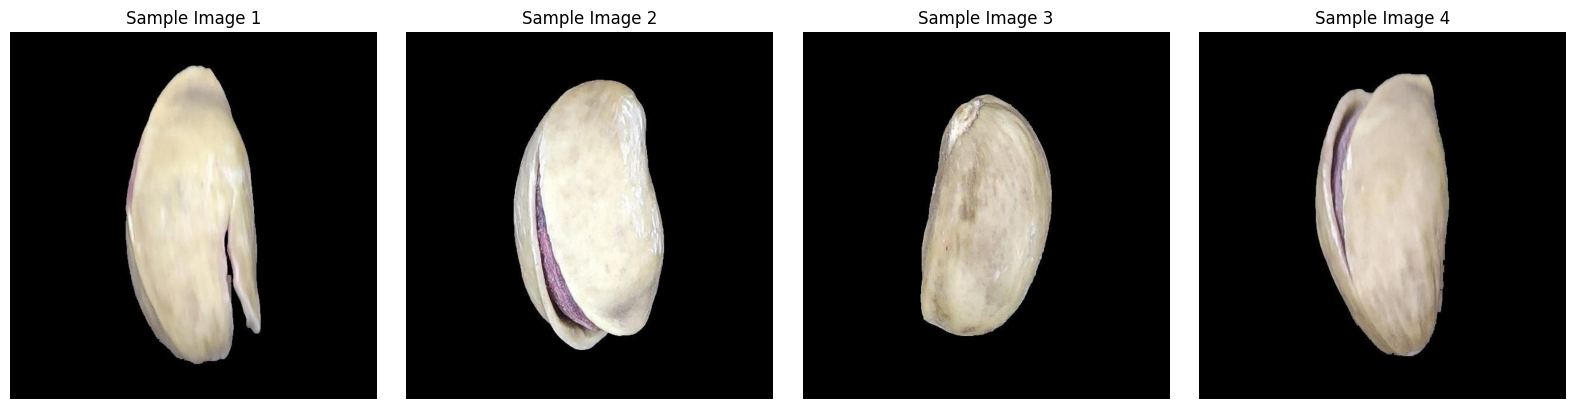

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i in range(4):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Sample Image {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Membuat plot distribusi RGB 

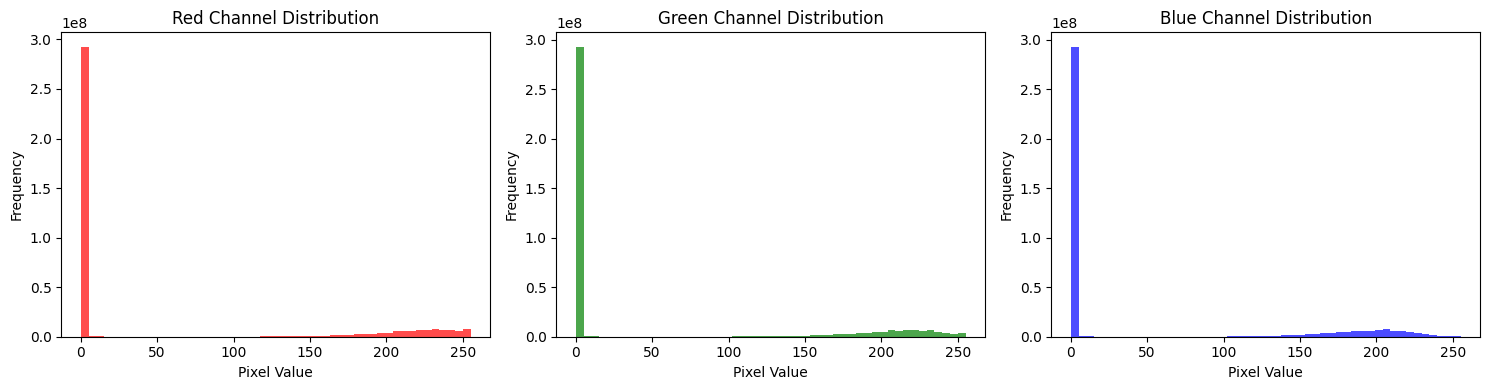

In [ ]:
colors = ['red', 'green', 'blue']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    channel_data = images[:, :, :, i].flatten()
    axes[i].hist(channel_data, bins=50, alpha=0.7, color=colors[i])
    axes[i].set_title(f'{colors[i].capitalize()} Channel Distribution')
    axes[i].set_xlabel('Pixel Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### dominan di pixel value 0 karena background item, dominan pixel value 220++ itu karena warnanya kepucatan kuning pucat (warna biji)

# Pre processing

### Preprocess dengan resize ke 100x100 dan normalize pixel ke 0-1

In [ ]:
from sklearn.model_selection import train_test_split

def preprocess_images(images, size=(100, 100)):
    preprocessed = []
    for img in images:
        img_resized = Image.fromarray(img).resize(size)
        img_array = np.array(img_resized) / 255.0 # normalize pixel
        preprocessed.append(img_array)
    return np.array(preprocessed)

x = preprocess_images(images)
print("Shape setelah resize:", x.shape)

Shape setelah resize: (1074, 100, 100, 3)


In [ ]:
x_train, x_temporary = train_test_split(x, test_size=0.2, random_state=SEED)
x_val, x_test = train_test_split(x_temporary, test_size=0.5, random_state=SEED)

print("Train:", x_train.shape)
print("Val  :", x_val.shape)
print("Test :", x_test.shape)

Train: (859, 100, 100, 3)
Val  : (107, 100, 100, 3)
Test : (108, 100, 100, 3)


### add gaussian model

In [ ]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, images.shape)
    noisy_images = np.clip(images + noise, 0.0, 1.0)
    return noisy_images

x_train_noisy = add_gaussian_noise(x_train)
x_val_noisy   = add_gaussian_noise(x_val)
x_test_noisy  = add_gaussian_noise(x_test)

### memastikan data float untuk input train

In [ ]:
x = x.astype(np.float32)
x_train_noisy = x_train_noisy.astype(np.float32)
x_train = x_train.astype(np.float32)
x_val_noisy = x_val_noisy.astype(np.float32)
x_val = x_val.astype(np.float32)

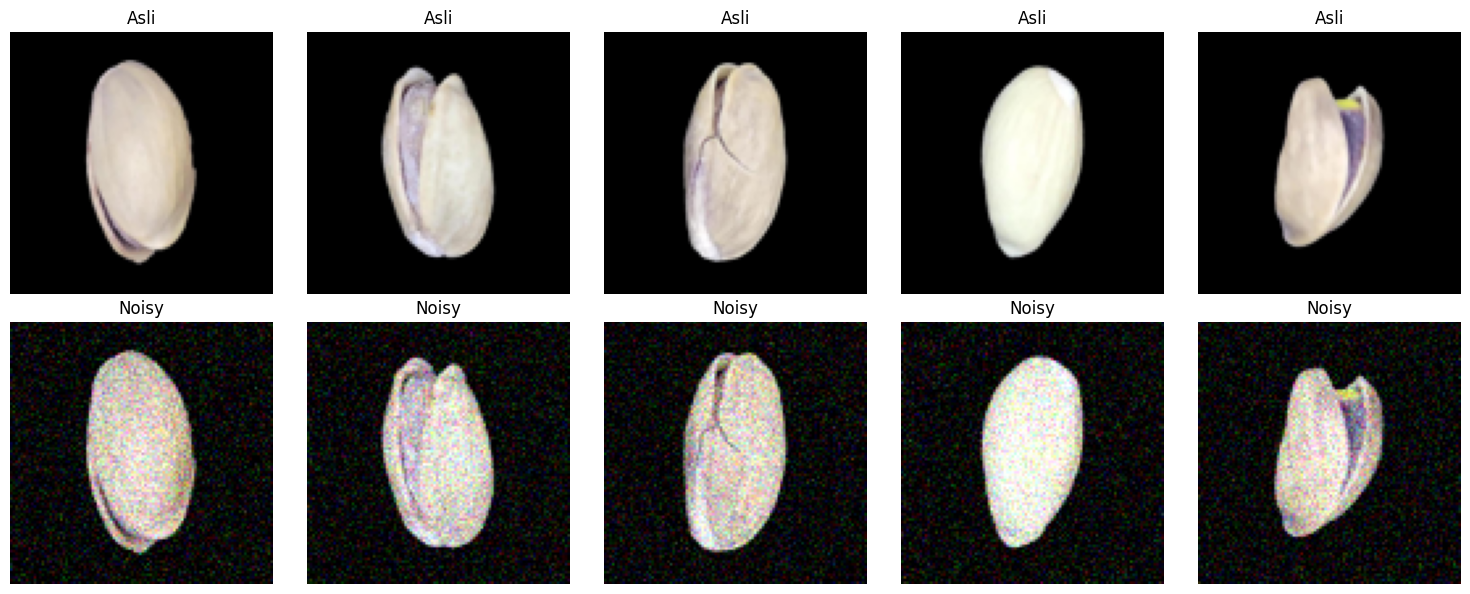

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    axes[0, i].imshow(x_train[i])
    axes[0, i].set_title("Asli")
    axes[0, i].axis('off')

    axes[1, i].imshow(x_train_noisy[i])
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def print_dataset_stats(name, original, noisy):
    print(f"{name} DATASET")
    print(f" Original Shape    : {original.shape}")
    print(f" Noisy Shape       : {noisy.shape}")
    print(f" Original Min/Max  : {original.min()} / {original.max()}")
    print(f" Noisy    Min/Max  : {noisy.min()} / {noisy.max()}")

print_dataset_stats("Train", x_train, x_train_noisy)
print_dataset_stats("Val",   x_val,   x_val_noisy)
print_dataset_stats("Test",  x_test,  x_test_noisy)

Train DATASET
 Original Shape    : (859, 100, 100, 3)
 Noisy Shape       : (859, 100, 100, 3)
 Original Min/Max  : 0.0 / 1.0
 Noisy    Min/Max  : 0.0 / 1.0
Val DATASET
 Original Shape    : (107, 100, 100, 3)
 Noisy Shape       : (107, 100, 100, 3)
 Original Min/Max  : 0.0 / 1.0
 Noisy    Min/Max  : 0.0 / 1.0
Test DATASET
 Original Shape    : (108, 100, 100, 3)
 Noisy Shape       : (108, 100, 100, 3)
 Original Min/Max  : 0.0 / 1.0
 Noisy    Min/Max  : 0.0 / 1.0


# Training

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

input_img = Input(shape=(100, 100, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

AE = Model(input_img, decoded)
AE.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
AE.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

history = AE.fit(
    x_train_noisy, x_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_val_noisy, x_val), #x noisy itu input , x val clean itu output (target)
    callbacks=[early_stopping]
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.1457 - val_loss: 0.0132
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0122 - val_loss: 0.0154
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0329 - val_loss: 0.0151
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0135 - val_loss: 0.0131
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0112 - val_loss: 0.0087
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0059 - val_loss: 0.0036
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/st

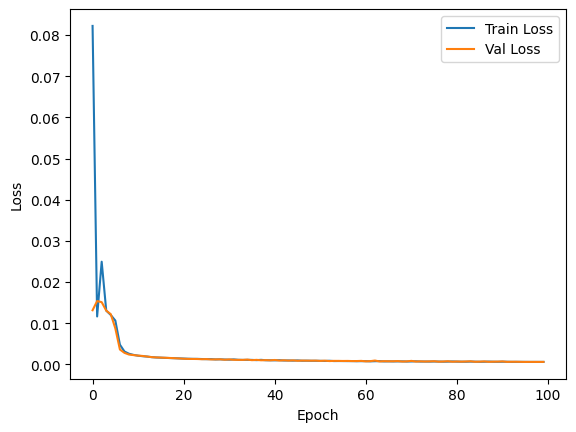

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### dipecah jadi 3 bagian
### Start: awal epoch turun dengan drastis kedua train dan val loss
### Mid: pada pertengahan epoch, terlihat kedua loss yang makin kecil dan stabil sangat stabil bahkan hingga menempel
### Akhir: tidak ada perubahan dari Mid phase, tetap stabil

### Kesimpulan: model berjalan dengan baik dan mengindikasikan very good fit, bisa dilihat dari train loss dan val loss yang turun berbarengan dan di angka yang rendah

# Modified

### menambahkan
### leakyRelu menggantikan relu, dimana tetap bisa kasih gradien kecil waktu input negatif
### tambah layer baru (depth)

In [ ]:
input_img = Input(shape=(100, 100, 3))

x = Conv2D(16, (3, 3), padding='same')(input_img)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Extra encoding depth
x = Conv2D(64, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), padding='same')(encoded)
x = LeakyReLU(alpha=0.1)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = Cropping2D(((2, 2), (2, 2)))(decoded)  # crop untuk fix dimensi

# Build Model
AE_mod = Model(input_img, decoded)
AE_mod.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
AE_mod.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 52, 52, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 104, 104, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 104, 104, 3)    │           435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 100, 100, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,035 (328.26 KB)

 Trainable params: 84,035 (328.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_mod = AE_mod.fit(
    x_train_noisy, x_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_val_noisy, x_val),
    callbacks=[early_stopping]
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - loss: 0.1561 - val_loss: 0.0116
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0083 - val_loss: 0.0058
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/ste

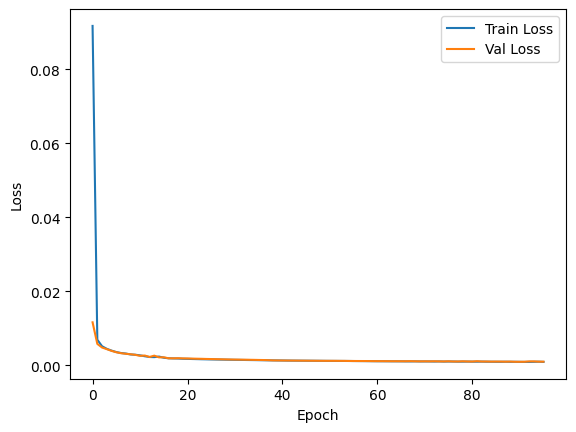

In [ ]:
train_loss = history_mod.history['loss']
val_loss = history_mod.history['val_loss']
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### dipecah jadi 3 bagian
### Start: awal epoch turun dengan drastis kedua train dan val loss
### Mid: pada pertengahan epoch, terlihat kedua loss yang makin kecil dan stabil sangat stabil bahkan hingga menempel
### Akhir: tidak ada perubahan dari Mid phase, tetap stabil

### Kesimpulan: model berjalan dengan baik dan mengindikasikan very good fit, bisa dilihat dari train loss dan val loss yang turun berbarengan dan di angka yang rendah

# Evaluasi

In [ ]:
decoded_imgs_base = AE.predict(x_test_noisy)
decoded_imgs_mod  = AE_mod.predict(x_test_noisy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


In [ ]:
def evaluate_ssim(y_true, y_pred):
    ssim_scores = []
    for i in range(len(y_true)):
        score = ssim(
            y_true[i], y_pred[i],
            channel_axis=2,
            data_range=1.0
        )
        ssim_scores.append(score)
    return np.mean(ssim_scores)

### SSIM - Metrik untuk membandingkan kemiripan visual antar gambar. Dari segi (Kontras, Struktur spasial, Terang dan gelap). Bisa dibilang seberapa bagus autoencoder meniru gambar asli.

In [ ]:
ssim_base = evaluate_ssim(x_test, decoded_imgs_base)
ssim_mod  = evaluate_ssim(x_test, decoded_imgs_mod)

print("Rata-rata SSIM model baseline  :", np.mean(ssim_base))
print("Rata-rata SSIM model modifikasi:", np.mean(ssim_mod))

Rata-rata SSIM model baseline  : 0.9579628270314567
Rata-rata SSIM model modifikasi: 0.9402678841290142


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


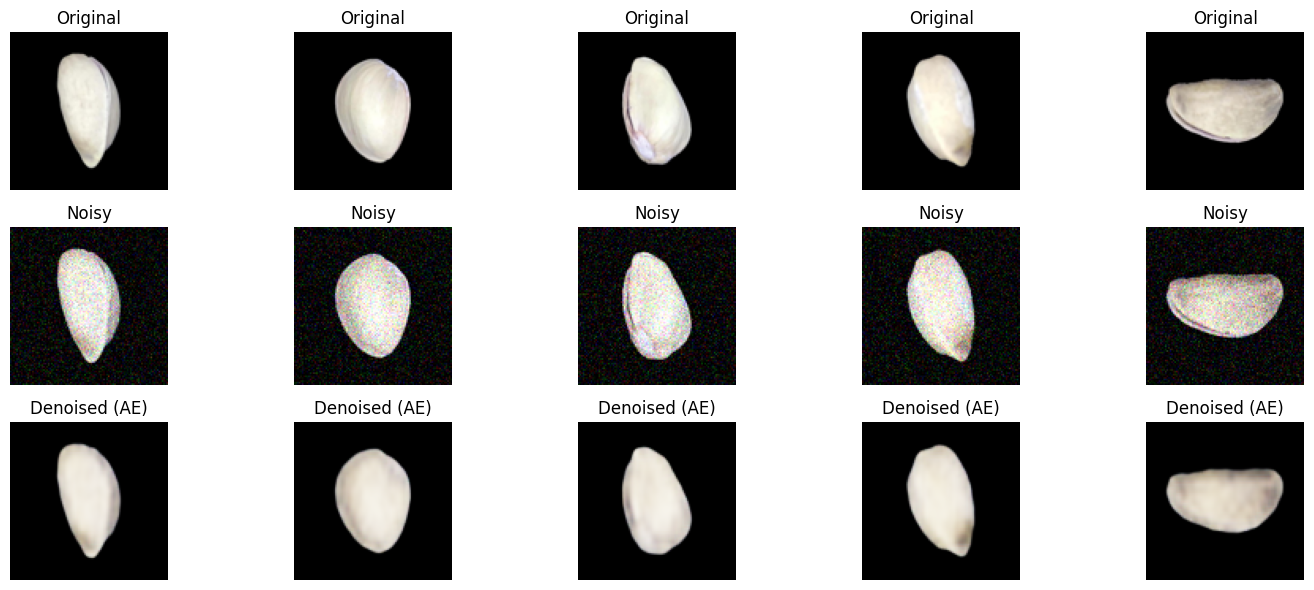

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n = 5  # jumlah gambar yang ingin ditampilkan
plt.figure(figsize=(15, 6))

for i in range(n):
    # Original (clean)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.axis("off")

    # Denoised by AE
    denoised = AE.predict(np.expand_dims(x_test_noisy[i], axis=0))[0]
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised)
    plt.title("Denoised (AE)")
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


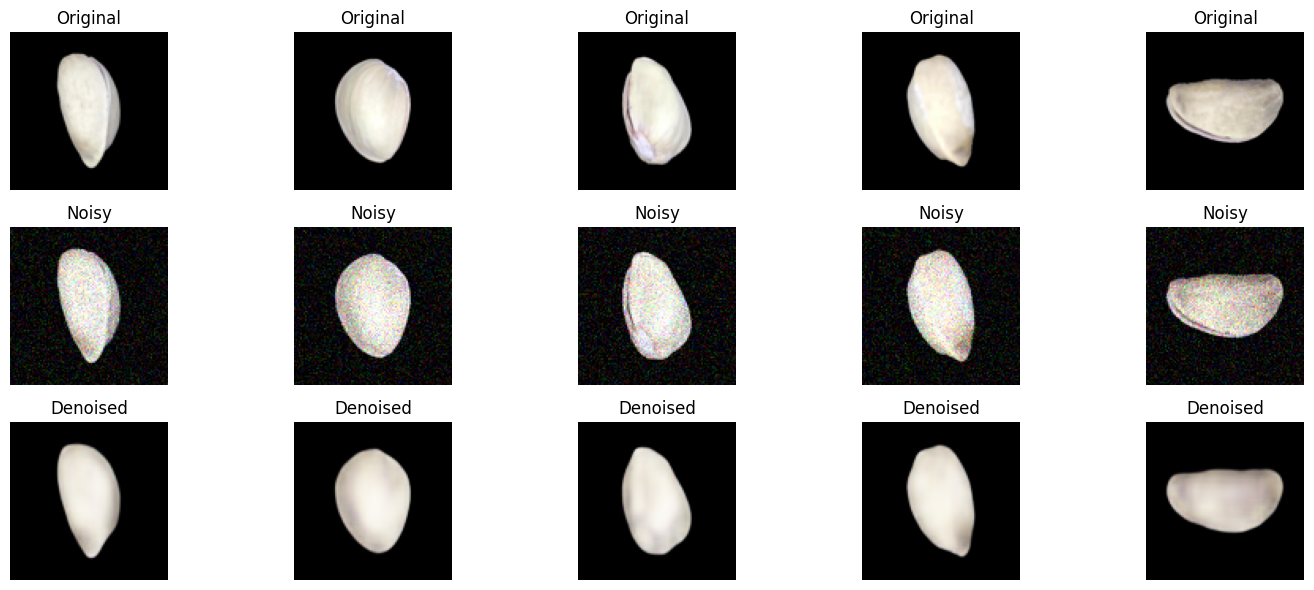

In [ ]:
import matplotlib.pyplot as plt

# Ambil beberapa sampel dari data validasi
n = 5  # jumlah gambar yang mau ditampilkan
plt.figure(figsize=(15, 6))

for i in range(n):
    # Asli (clean)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.axis("off")

    # Denoised (hasil prediksi AE)
    denoised_img = AE_mod.predict(np.expand_dims(x_test_noisy[i], axis=0))  # hasilnya (1, 100, 100, 3)
    denoised_img = denoised_img[0]  # ambil dari batch
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_img)
    plt.title("Denoised")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Hypertuning dari baseline model karena performs lebih bagus

In [ ]:
def build_autoencoder(hidden_size=32, learning_rate=0.001):
    input_img = Input(shape=(100, 100, 3))

    # Encoder
    x = Conv2D(hidden_size // 2, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(hidden_size, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(hidden_size, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(hidden_size // 2, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Model
    tuned_AE = Model(input_img, decoded)
    tuned_AE.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

    return tuned_AE

In [ ]:
results = []
hidden_sizes = [16, 32, 64]
learning_rates = [0.001, 0.005]

for hs in hidden_sizes:
    for lr in learning_rates:
        print(f"Training with hidden_size={hs}, learning_rate={lr}")
        model = build_autoencoder(hidden_size=hs, learning_rate=lr)

        early_stop = EarlyStopping(patience=5, restore_best_weights=True)
        history = model.fit(
            x_train_noisy, x_train,
            epochs=100,
            batch_size=32,
            validation_data=(x_val_noisy, x_val),
            callbacks=[early_stop]
        )

        val_loss = min(history.history["val_loss"])
        results.append({
            "hidden_size": hs,
            "learning_rate": lr,
            "val_loss": val_loss
        })

Training with hidden_size=16, learning_rate=0.001
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - loss: 0.1810 - val_loss: 0.0634
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0415 - val_loss: 0.0104
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029 - val_loss: 0.0029
E

In [ ]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="val_loss")
print(df_results)

   hidden_size  learning_rate  val_loss
5           64          0.005  0.000425
4           64          0.001  0.000480
3           32          0.005  0.000498
1           16          0.005  0.000658
2           32          0.001  0.000834
0           16          0.001  0.000857


In [ ]:
results_df = pd.DataFrame(results)

best_result = results_df.loc[results_df['val_loss'].idxmin()]
best_hs = best_result['hidden_size']
best_lr = best_result['learning_rate']

print(f"Best Hidden Size: {best_hs}, Best Learning Rate: {best_lr}")

Best Hidden Size: 64.0, Best Learning Rate: 0.005


In [ ]:
best_model = build_autoencoder(hidden_size=64, learning_rate=0.005)

best_model.fit(
    x_train_noisy, x_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_val_noisy, x_val),
    callbacks=[early_stopping]
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0714 - val_loss: 0.0046
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

In [ ]:
x_test_pred = best_model.predict(x_test_noisy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


In [ ]:
tuned_ssim_score = evaluate_ssim(x_test, x_test_pred)
print(f"Test SSIM Score: {tuned_ssim_score}")

Test SSIM Score: 0.9639135498596465


### Hasil tuning lebih bagus, units sama dengan baseline (64), tapi learning rate 0.005 ternyata performs better, walau kenaikan hanya 1%, tapi 1% tetaplah improvement!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


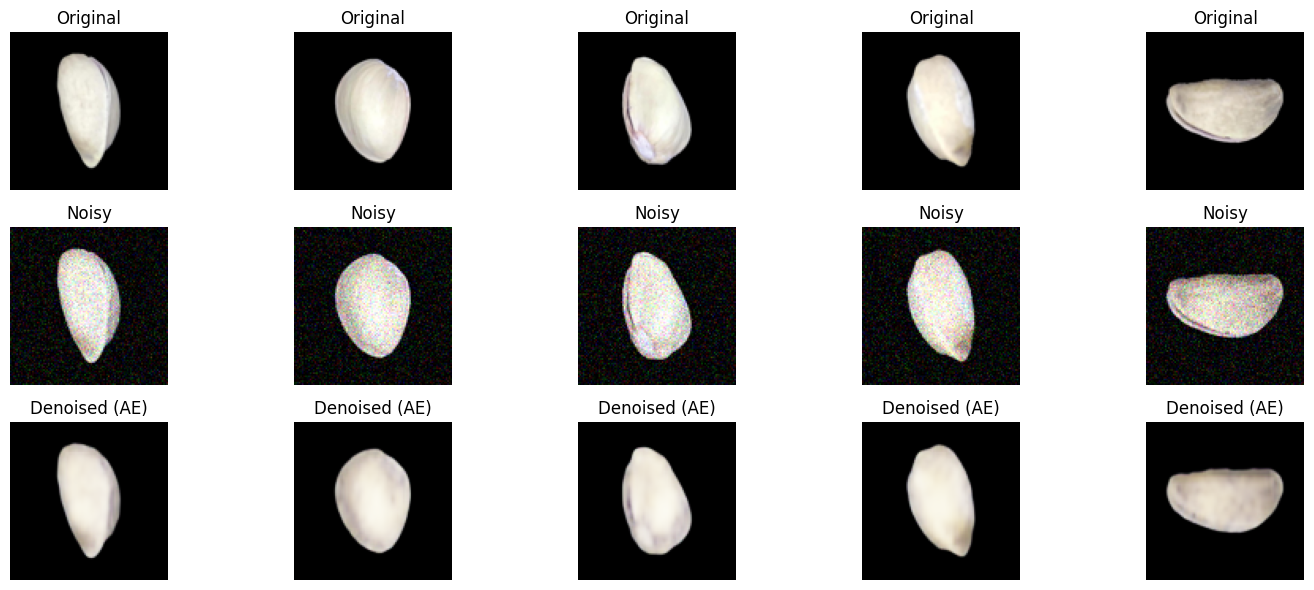

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n = 5  # jumlah gambar yang ingin ditampilkan
plt.figure(figsize=(15, 6))

for i in range(n):
    # Original (clean)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.axis("off")

    # Denoised by AE
    denoised = best_model.predict(np.expand_dims(x_test_noisy[i], axis=0))[0]
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised)
    plt.title("Denoised (AE)")
    plt.axis("off")

plt.tight_layout()
plt.show()

https://drive.google.com/drive/folders/1_ggwBIIaDgdvG_25tj3mQFZHsJm7EJbI?usp=sharing